In [1]:
#@title Imports
from IPython.display import clear_output
import time
import numpy as np
import math
from collections import namedtuple
import random
from tqdm.notebook import tqdm
import torch
import torch.nn as nn   
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim   
import torch.nn.functional as F
import torch.distributions.normal as Normal
from matplotlib import pyplot as plt
from math import pi as pi
random.seed(1)
torch.manual_seed(1)
np.random.seed(1)

In [2]:
#@title Choose device
device = 'cuda'

In [3]:
#@title Cartpole Environment
class Cartpole:
    def __init__(self, init_state, action_interval):
        self.m1 = 0.5
        self.m2 = 0.5
        self.l = 0.6
        self.b = 0.1
        self.g = 9.82
        self.dt = 0.01
        self.Tinv = torch.tensor([[1., self.l, 0.],
                                  [self.l, self.l**2, 0.], 
                                  [0., 0., self.l**2]])
        self.jtarget = torch.tensor([0., 0., 1.])
        self.T = action_interval
        self.action_time = int(self.T/self.dt)
        self.init_state = init_state.clone().detach()
        self.current_state = init_state.clone().detach()

        self.action_lb = -10.
        self.action_ub = 10.

    def reset(self, ):
        self.current_state = self.init_state.clone().detach()


    def euler_step(self, action):
        x = self.current_state
        x[2] = -x[2]+pi;
        x = (x + self.dt
                * (torch.tensor([
                                 x[1], 
                                 (2*self.m2*self.l*x[3]**2*torch.sin(x[2]) + 3*self.m2*self.g*torch.sin(x[2])*torch.cos(x[2]) 
                                 + 4*action - 4*self.b*x[1])/(4*(self.m1+self.m2) - 3*self.m2*torch.cos(x[2])**2), 
                                 x[3], 
                                 (-3*self.m2*self.l*x[3]**2*torch.sin(x[2])*torch.cos(x[2]) - 6*(self.m1+self.m2)*self.g*torch.sin(x[2]) 
                                 - 6*(action-self.b*x[1])*torch.cos(x[2]))/(4*self.l*(self.m1+self.m2) - 3*self.m2*self.l*torch.cos(x[2])**2)
                                 ])
                    )
             )
                
        # Check boundaries
        # pos
        if x[0] > 6:
            x[0] = 6
            x[1] = -0.5*x[1]
        elif x[0] < -6:
            x[0] = -6
            x[1] = -0.5*x[1]
        
        # pos_dot
        if x[1] > 10:
            x[1] = 10
        elif x[1] < -10:
            x[1] = -10
        
        # theta
        x[2] = -(x[2]-pi)
        if x[2] > pi:
            x[2] = -(2*pi - x[2])
        elif x[2] < -pi:
            x[2] = (2*pi + x[2])
        
        # theta_dot
        if x[3] > 10:
            x[3] = 10
        elif x[3] < -10:
            x[3] = -10

        self.current_state = x

    def step(self, action):
        for _ in range(self.action_time):
            self.euler_step(action)
        x = self.current_state
        j = torch.tensor([x[0], torch.sin(x[2]), torch.cos(x[2])])
        jj = j - self.jtarget
        reward = torch.tensor([-(1-torch.exp(-0.5*(jj @ self.Tinv @ jj.T )))])
        return self.current_state, reward

def test():
    x = torch.zeros(T_test,4)
    r = torch.zeros(T_test,1)
    actor_net.eval()
    env.reset()                   
    for t in range(T_test):
        with torch.no_grad():
            action = select_action(env.current_state.to(device).unsqueeze(0),greedy=True)
        x[t], r[t] = env.step(action)
    return sum(r), x

In [4]:
#@title Memory
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
#@title Select action
def select_action(state, greedy = False):
    actor_net.eval()
    with torch.no_grad():
        mu, sigma = actor_net(state)
        if greedy:
            action = mu
        else:             
            action = mu+sigma*torch.randn(1).to(device) 
        
        if action < env.action_lb:
            action = torch.tensor([[env.action_lb]]).to(device) 
        elif action > env.action_ub:
            action = torch.tensor([[env.action_ub]]).to(device) 
    return action

In [6]:
#@title Update networks
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return 0, 0           

    # Sample mini-batch from memory buffer
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    next_state_batch = torch.cat(batch.next_state)

    # Compute loss critic
    critic_net.train()
    optimizer_critic.zero_grad() 
    with torch.no_grad():
        next_state_values = target_critic_net(next_state_batch)
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss_critic = F.mse_loss(critic_net(state_batch), expected_state_action_values)

    # Optimize critic
    loss_critic.backward()
    optimizer_critic.step()

    # Compute loss actor
    actor_net.train()
    optimizer_actor.zero_grad()
    critic_net.eval()
    with torch.no_grad():
        next_state_values = critic_net(next_state_batch)
        state_action_values = critic_net(state_batch)
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch
        diff = expected_state_action_values - state_action_values
        mu, sigma = target_actor_net(state_batch)
        m = Normal.Normal(mu, sigma)
        log_probs = m.log_prob(action_batch)
        targets = log_probs + diff*BETA

    mu, sigma = actor_net(state_batch)
    m = Normal.Normal(mu, sigma)
    log_probs = m.log_prob(action_batch)
    loss_actor = F.mse_loss(log_probs, targets)

    # Optimize actor
    loss_actor.backward()
    optimizer_actor.step()

    return loss_actor.item(), loss_critic.item()

In [7]:
#@title Model classes
class Actor(nn.Module):
    def __init__(self, input_dim):
        super(Actor, self).__init__()
        self.nunits = 1000
        self.h = nn.ReLU()
        self.fc1 = nn.Linear(input_dim, self.nunits)
        self.fc2 = nn.Linear(self.nunits, self.nunits)
        self.fc3 = nn.Linear(self.nunits, self.nunits)
        self.fc4 = nn.Linear(self.nunits, self.nunits)
        self.fc5 = nn.Linear(self.nunits, self.nunits)
        self.mu = nn.Linear(self.nunits, 1)
        self.sigma = nn.Linear(self.nunits, 1)

    def forward(self, x):
        x = self.h(self.fc1(x))
        x = self.h(self.fc2(x))
        x = self.h(self.fc3(x))
        x = self.h(self.fc4(x))
        x = self.h(self.fc5(x))
        return 10*F.tanh(self.mu(x)), 5*F.sigmoid(self.sigma(x))

class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.nunits = 1000
        self.h = nn.ReLU()
        self.fc1 = nn.Linear(input_dim, self.nunits)
        self.fc2 = nn.Linear(self.nunits, self.nunits)
        self.fc3 = nn.Linear(self.nunits, self.nunits)
        self.fc4 = nn.Linear(self.nunits, self.nunits)
        self.fc5 = nn.Linear(self.nunits, self.nunits)
        self.head = nn.Linear(self.nunits, 1)

    def forward(self, x):
        x = self.h(self.fc1(x))
        x = self.h(self.fc2(x))
        x = self.h(self.fc3(x))
        x = self.h(self.fc4(x))
        x = self.h(self.fc5(x))
        return self.head(x)

In [8]:
#@title Initialize
env = Cartpole(torch.tensor([0, 0, pi, 0,]), 0.1)
state_dim = 4
memory = ReplayMemory(2000)

steps_done = 0

actor_net = Actor(state_dim).to(device)
target_actor_net = Actor(state_dim).to(device)
target_actor_net.load_state_dict(actor_net.state_dict())
target_actor_net.eval()

critic_net = Critic(state_dim).to(device)
target_critic_net = Critic(state_dim).to(device)
target_critic_net.load_state_dict(critic_net.state_dict())
target_critic_net.eval()

optimizer_actor = optim.Adam(actor_net.parameters(), lr=1e-4)
optimizer_critic = optim.Adam(critic_net.parameters(), lr=1e-4)
acc_reward = []

In [9]:
#@title Training
BATCH_SIZE = 128
GAMMA = 0.9
BETA = 0.3
num_episodes = 500
episode_len = 50
ACTOR_TARGET_UPDATE = 100
CRITC_TARGET_UPDATE = 100
TEST_UPDATE = 1000
T_test = 50
for i_episode in tqdm(range(num_episodes)):
    loss_c = 0
    loss_a = 0
    # Initialize the environment and state
    env.reset()
    state = env.current_state.unsqueeze(0).to(device)
    for t in range(episode_len):
        # Select and perform an action
        action = select_action(state)
        next_state, reward  = env.step(action.item())
        next_state = next_state.unsqueeze(0).to(device)
        reward = reward.unsqueeze(0).to(device)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        steps_done += 1

        # Move to the next state
        state = next_state

        # Perform one step of the optimization
        la, lc = optimize_model()
        if la:
            loss_a += la
            loss_c += lc
        # Update the target networks
        if steps_done % CRITC_TARGET_UPDATE == 0:
            target_critic_net.load_state_dict(critic_net.state_dict())
        if steps_done % ACTOR_TARGET_UPDATE == 0:
            target_actor_net.load_state_dict(actor_net.state_dict())
        if steps_done > 3000:
            BETA = 0.5
        if steps_done > 5000:
            BETA = 1
        if steps_done > 10000:
            BETA = 1.5
        if steps_done % TEST_UPDATE == 0 :
            r , _ = test()
            acc_reward.append(r)
    print('Episode {}, Steps {}, BETA {:.1f}: actor-loss {:.2e}, critic-loss {:.2e}'.format(i_episode, steps_done, BETA, loss_a/episode_len, loss_c/episode_len))
print('Complete')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Episode 0, Steps 50, BETA 0.3: actor-loss 0.00e+00, critic-loss 0.00e+00
Episode 1, Steps 100, BETA 0.3: actor-loss 0.00e+00, critic-loss 0.00e+00
Episode 2, Steps 150, BETA 0.3: actor-loss 1.07e-02, critic-loss 3.92e-02
Episode 3, Steps 200, BETA 0.3: actor-loss 1.60e-02, critic-loss 9.28e-03
Episode 4, Steps 250, BETA 0.3: actor-loss 1.74e-02, critic-loss 4.27e-02
Episode 5, Steps 300, BETA 0.3: actor-loss 1.32e-02, critic-loss 7.08e-03
Episode 6, Steps 350, BETA 0.3: actor-loss 2.08e-02, critic-loss 4.65e-02
Episode 7, Steps 400, BETA 0.3: actor-loss 1.05e-02, critic-loss 8.38e-03
Episode 8, Steps 450, BETA 0.3: actor-loss 1.73e-02, critic-loss 3.88e-02
Episode 9, Steps 500, BETA 0.3: actor-loss 1.06e-02, critic-loss 6.85e-03
Episode 10, Steps 550, BETA 0.3: actor-loss 1.86e-02, critic-loss 4.32e-02
Episode 11, Steps 600, BETA 0.3: actor-loss 2.74e-02, critic-loss 1.22e-02
Episode 12, Steps 650, BETA 0.3: actor-loss 1.30e-02, critic-loss 4.75e-02
Episode 13, Steps 700, BETA 0.3: act

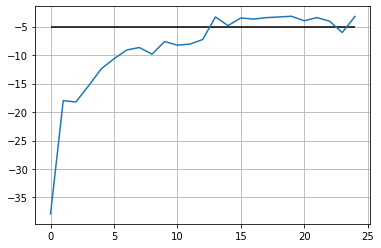

In [10]:
#@title Plot accumulated reward
plt.plot(acc_reward)
plt.hlines(-5,0,len(acc_reward)-1)
plt.grid()
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


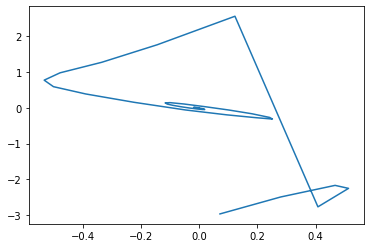

In [11]:
#@title Simulate Trajectory
T_test = 100
r, x = test()
plt.plot(x[:,0],x[:,2])
plt.show()

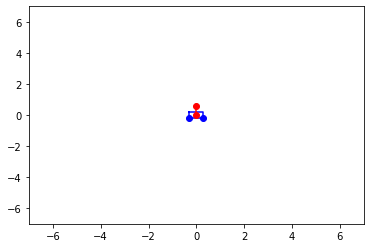

In [12]:
#@title Simulate Cartpole
trajec = x
i = 0;
while i < T_test:
    angle = trajec[i, 2]
    car_pos = torch.tensor([trajec[i, 0], 0])
    pend_pos = car_pos+torch.tensor([0.6*torch.cos(angle+pi/2), 0.6*torch.sin(angle+pi/2)])
    plt.plot([car_pos[0]-0.3, car_pos[0]+0.3, car_pos[0]+0.3, car_pos[0]-0.3, car_pos[0]-0.3],
        [car_pos[1]+0.2, car_pos[1]+0.2, car_pos[1]-0.2, car_pos[1]-0.2, car_pos[1]+0.2],'b')
    plt.plot([car_pos[0]+0.3, car_pos[0]-0.3],[car_pos[1]-0.2, car_pos[1]-0.2], 'ob')
    plt.plot([car_pos[0], pend_pos[0]], [car_pos[1], pend_pos[1]], '-or')
    plt.xlim([-7, 7])
    plt.ylim([-7, 7])
    plt.show()
    
    clear_output(wait=True)
    time.sleep(0.09)  
    i += 1